In [1]:
# Common imports
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from tensorflow.keras.utils import get_file
from keras.callbacks import Callback
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
from tensorflow.keras.utils import to_categorical

K.set_image_data_format('channels_last')
K.set_learning_phase(1)
%matplotlib inline


2023-11-25 12:43:23.824624: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 12:43:23.824672: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 12:43:23.824723: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 12:43:23.833573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 12:43:24.590269: W tensorflow/compiler/

In [2]:
 def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
#from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.initializers import glorot_uniform
def ResNet50(input_shape=(28, 28, 1), classes=5):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    

    # Stage 2
    X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=3, block='a', s=2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=4, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=5, block='a', s=2)
    X = identity_block(X, 3, [64, 64, 256], stage=5, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model



In [5]:
model = ResNet50(input_shape=(28, 28, 1), classes=5)  # Use 10 as the number of classes


2023-11-25 12:43:25.254800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 12:43:25.288419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 12:43:25.288724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 34, 34, 1)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 28, 28, 32)           1600      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 28, 28, 32)           128       ['conv1[0][0]']        

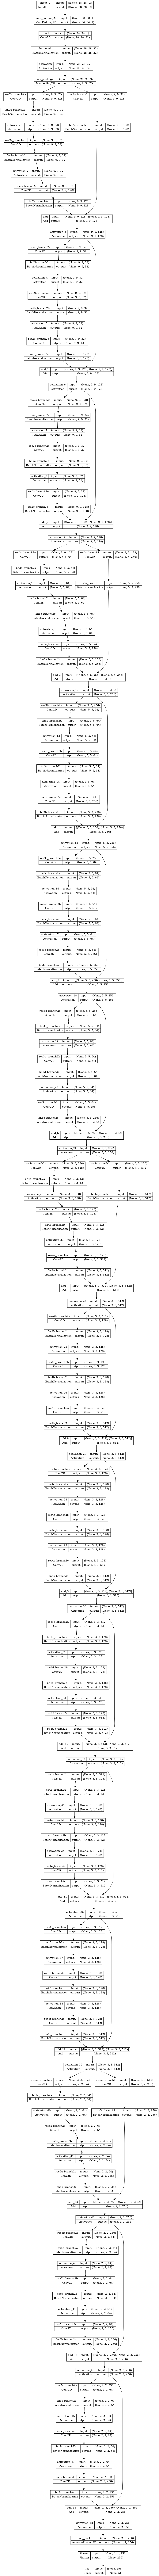

In [7]:
plot_model(model, show_shapes=True, to_file = 'resnet_arch.png')

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [9]:
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range = 10)
train_images = train_datagen.flow_from_directory('/home/mrroy/DR/CLASS/train/', color_mode='grayscale', target_size=(28, 28), batch_size=32)
val_datagen = ImageDataGenerator(rescale=1.0/255)
validation_images = val_datagen.flow_from_directory('/home/mrroy/DR/CLASS/validation/', color_mode='grayscale', target_size=(28, 28), batch_size=32)


Found 87105 images belonging to 5 classes.
Found 12443 images belonging to 5 classes.


In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
STEP_SIZE_TRAIN = train_images.n//train_images.batch_size
STEP_SIZE_VALID = validation_images.n//validation_images.batch_size
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath='models/resnet_model_original_after_dcgan.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', verbose=1)

# Create a list of callbacks, including ModelCheckpoint and EarlyStopping
callbacks_list = [checkpoint, early_stopping]

# Start training
history = model.fit_generator(generator=train_images,
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=validation_images,
                               validation_steps=STEP_SIZE_VALID,
                               callbacks=callbacks_list,
                               epochs=50)


Epoch 1/50


/tmp/ipykernel_42292/2386661573.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_images,
2023-11-25 12:43:40.033931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-25 12:43:40.748918: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc2f0041ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 12:43:40.748959: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-11-25 12:43:40.757645: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 12:43:40.898629: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA! 

2722/2722 [==============================] - ETA: 0s - loss: 1.0641 - accuracy: 0.5448
Epoch 1: val_accuracy improved from -inf to 0.59222, saving model to models/resnet_model_original_after_dcgan.h5


/home/mrroy/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2722/2722 [==============================] - 154s 48ms/step - loss: 1.0641 - accuracy: 0.5448 - val_loss: 0.9755 - val_accuracy: 0.5922
Epoch 2/50
2721/2722 [============================>.] - ETA: 0s - loss: 0.9116 - accuracy: 0.6127
Epoch 2: val_accuracy did not improve from 0.59222
2722/2722 [==============================] - 131s 48ms/step - loss: 0.9117 - accuracy: 0.6126 - val_loss: 1.1663 - val_accuracy: 0.5644
Epoch 3/50
2722/2722 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.6425
Epoch 3: val_accuracy did not improve from 0.59222
2722/2722 [==============================] - 136s 50ms/step - loss: 0.8514 - accuracy: 0.6425 - val_loss: 1.2016 - val_accuracy: 0.5427
Epoch 4/50
2721/2722 [============================>.] - ETA: 0s - loss: 0.8382 - accuracy: 0.6501
Epoch 4: val_accuracy improved from 0.59222 to 0.66801, saving model to models/resnet_model_original_after_dcgan.h5
2722/2722 [==============================] - 136s 50ms/step - loss: 0.8381 - acc

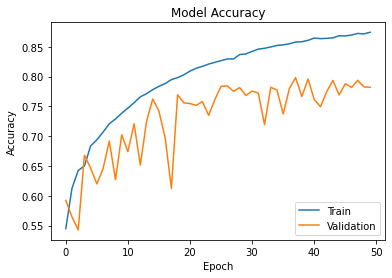

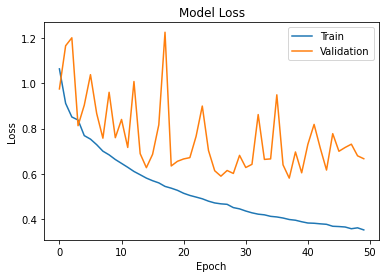

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [12]:
train_images.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [13]:
validation_images.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [14]:
from keras.models import load_model
m = load_model('/home/mrroy/DR/models/resnet_model_original_after_dcgan.h5')

In [15]:
from sklearn.metrics import classification_report, precision_score, confusion_matrix, accuracy_score, f1_score, recall_score

In [16]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_images = test_datagen.flow_from_directory('/home/mrroy/DR/CLASS/test/',  color_mode = 'grayscale', target_size = (28, 28), batch_size = 16, shuffle = False)

Found 24882 images belonging to 5 classes.


In [17]:
y_pred = m.predict_generator(generator = test_images, verbose = 1)

/tmp/ipykernel_42292/4096225954.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = m.predict_generator(generator = test_images, verbose = 1)


1556/1556 [==============================] - 17s 10ms/step


In [18]:
y_pred

array([[7.6223570e-01, 6.1700650e-02, 1.5451300e-01, 1.5433381e-02,
        6.1172401e-03],
       [7.3350036e-01, 3.9458472e-02, 1.9522569e-01, 2.3073450e-02,
        8.7420642e-03],
       [7.4348009e-01, 1.6891342e-02, 1.7819588e-01, 2.2381997e-02,
        3.9050698e-02],
       ...,
       [1.0196040e-06, 1.4585472e-04, 7.8150009e-08, 9.7073710e-01,
        2.9115899e-02],
       [4.3030693e-07, 1.8442234e-02, 2.7749394e-07, 2.8809257e-02,
        9.5274782e-01],
       [3.7342531e-06, 3.0694145e-04, 1.6036908e-07, 6.4869523e-02,
        9.3481964e-01]], dtype=float32)

In [19]:
y_pred = y_pred.argmax(axis=-1)

In [20]:
y_pred

array([0, 0, 0, ..., 3, 4, 4])

In [21]:
print(classification_report(test_images.classes[test_images.index_array], y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      5162
           1       0.79      0.72      0.75      4952
           2       0.81      0.71      0.76      5523
           3       0.85      0.82      0.84      4639
           4       0.91      0.81      0.85      4606

    accuracy                           0.81     24882
   macro avg       0.82      0.81      0.81     24882
weighted avg       0.82      0.81      0.81     24882



In [22]:
print('precision')
p1 = precision_score(test_images.classes[test_images.index_array], y_pred, average = 'weighted')
print(p1*100)
print('recall')
r1 = recall_score(test_images.classes[test_images.index_array], y_pred, average = 'weighted')
print(r1*100)
print('f1')
f11 = f1_score(test_images.classes[test_images.index_array], y_pred, average = 'weighted')
print(f11*100)
print('accuracy')
a1 = accuracy_score(test_images.classes[test_images.index_array], y_pred)
print(a1*100)


precision
81.77947432020355
recall
81.05457760630175
f1
80.84939906854385
accuracy
81.05457760630175


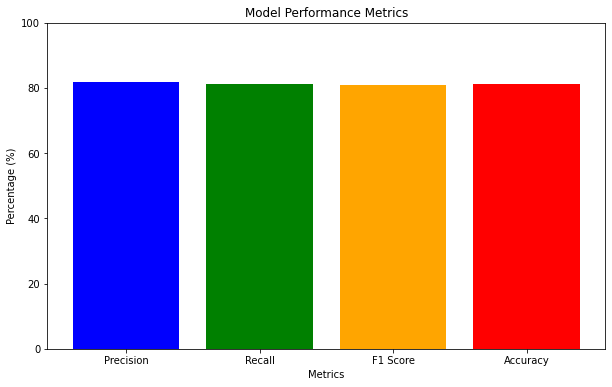

In [23]:
import matplotlib.pyplot as plt

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
recall = recall_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
f1_score = f1_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
accuracy = accuracy_score(test_images.classes[test_images.index_array], y_pred)

# Convert scores to percentages
precision_percent = precision * 100
recall_percent = recall * 100
f1_score_percent = f1_score * 100
accuracy_percent = accuracy * 100

# Create a bar plot for the performance metrics
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [precision_percent, recall_percent, f1_score_percent, accuracy_percent]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 100)
plt.xlabel('Metrics')
plt.ylabel('Percentage (%)')
plt.title('Model Performance Metrics')
plt.show()


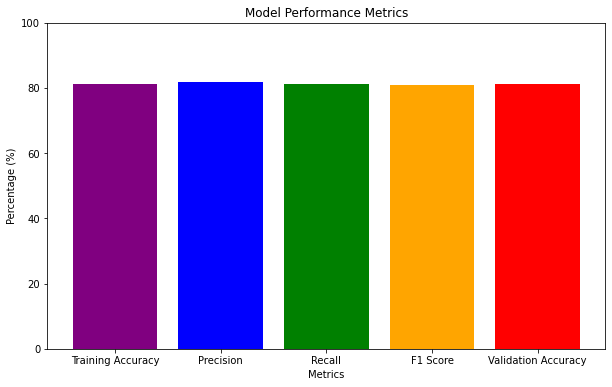

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
recall = recall_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
f1_score = f1_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
accuracy = accuracy_score(test_images.classes[test_images.index_array], y_pred)

# Convert scores to percentages
precision_percent = precision * 100
recall_percent = recall * 100
f1_score_percent = f1_score * 100
accuracy_percent = accuracy * 100

# Training accuracy
training_accuracy_percent = a1 * 100

# Create a bar plot for the performance metrics
metrics = ['Training Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Accuracy']
values = [training_accuracy_percent, precision_percent, recall_percent, f1_score_percent, accuracy_percent]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['purple', 'blue', 'green', 'orange', 'red'])
plt.ylim(0, 100)
plt.xlabel('Metrics')
plt.ylabel('Percentage (%)')
plt.title('Model Performance Metrics')
plt.show()


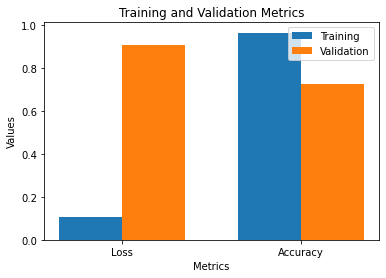

In [26]:
import matplotlib.pyplot as plt

# Define the values from your log
training_loss = 0.1045
training_accuracy = 0.9638
validation_loss = 0.9066
validation_accuracy = 0.7253

# Create lists for the values
metrics = ['Loss', 'Accuracy']
training_values = [training_loss, training_accuracy]
validation_values = [validation_loss, validation_accuracy]

# Create bar positions for training and validation
x = range(len(metrics))

# Create the bar plot
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, training_values, width, label='Training')
rects2 = ax.bar([i + width for i in x], validation_values, width, label='Validation')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Training and Validation Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(metrics)
ax.legend()

# Display the plot
plt.show()


In [27]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [28]:
x = confusion_matrix(test_images.classes[test_images.index_array], y_pred)

In [29]:
import pandas as pd
df = pd.DataFrame(x)

In [30]:
df.to_csv('confusion.csv')

In [31]:
test_images.classes[test_images.index_array]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_images = test_datagen.flow_from_directory('/home/mrroy/DR/CLASS/test/',  color_mode = 'grayscale', target_size = (28, 28), batch_size = 16, shuffle = False)
p = m.evaluate_generator(test_images, verbose=1, steps=test_images.n//test_images.batch_size)
print(p)


Found 24882 images belonging to 5 classes.


/tmp/ipykernel_42292/1691506447.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  p = m.evaluate_generator(test_images, verbose=1, steps=test_images.n//test_images.batch_size)


1555/1555 [==============================] - 17s 11ms/step - loss: 0.5451 - accuracy: 0.8105
[0.5450931787490845, 0.8105305433273315]


In [33]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_images = test_datagen.flow_from_directory('/home/mrroy/DR/CLASS/test/',  color_mode = 'grayscale', target_size = (28, 28), batch_size = 32)
p = m.evaluate_generator(test_images, verbose=1, steps=test_images.n//test_images.batch_size)
print(p)

Found 24882 images belonging to 5 classes.
 11/777 [..............................] - ETA: 8s - loss: 0.5802 - accuracy: 0.7898

/tmp/ipykernel_42292/2595968230.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  p = m.evaluate_generator(test_images, verbose=1, steps=test_images.n//test_images.batch_size)


777/777 [==============================] - 9s 12ms/step - loss: 0.5451 - accuracy: 0.8105
[0.5450767278671265, 0.8105292916297913]


In [34]:
from keras.models import load_model
m = load_model('/home/mrroy/DR/models/resnet_model_original_after_dcgan.h5')

In [35]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_images = test_datagen.flow_from_directory('/home/mrroy/DR/CLASS/test/',  color_mode = 'grayscale', target_size = (28, 28), batch_size = 32, shuffle = False)

Found 24882 images belonging to 5 classes.


In [36]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

# Assuming 'm' is your model and 'test_images' is your test data generator

y_pred = m.predict_generator(generator=test_images, verbose=1)
y_pred = y_pred.argmax(axis=-1)

print(classification_report(test_images.classes[test_images.index_array], y_pred))

print('precision')
precision_value = precision_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
print(precision_value * 100)

print('recall')
recall_value = recall_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
print(recall_value * 100)

print('f1')
f1_value = f1_score(test_images.classes[test_images.index_array], y_pred, average='weighted')
print(f1_value * 100)

print('accuracy')
accuracy_value = accuracy_score(test_images.classes[test_images.index_array], y_pred)
print(accuracy_value * 100)


/tmp/ipykernel_42292/977660437.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = m.predict_generator(generator=test_images, verbose=1)


778/778 [==============================] - 11s 13ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      5162
           1       0.79      0.72      0.75      4952
           2       0.81      0.71      0.76      5523
           3       0.85      0.82      0.84      4639
           4       0.91      0.81      0.85      4606

    accuracy                           0.81     24882
   macro avg       0.82      0.81      0.81     24882
weighted avg       0.82      0.81      0.81     24882

precision
81.77947432020355
recall
81.05457760630175
f1
80.84939906854385
accuracy
81.05457760630175
